In [1]:
dataset = "purchase100"
algorithm = "adversarial training"

### 1. Load Dataset

In [2]:
import numpy as np 
from art.utils import to_categorical

x = []
y = []

with open("data/dataset_purchase", "r") as f:
    for datapoint in f.readlines(): 
        split = datapoint.rstrip().split(",")
        label = int(split[0]) - 1
        x.append([int(s) for s in split[1:]])
        y.append(label)

x = np.array(x).astype(np.float32)
y = to_categorical(np.array(y), 100)

target_train_size = 10000
target_test_size = 10000
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def purchase_model(): 
    model = nn.Sequential(            
        nn.Linear(600, 128),
        nn.ReLU(),
        nn.Linear(128, 100)
    )
    return model

summary(purchase_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          76,928
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 100]          12,900
Total params: 89,828
Trainable params: 89,828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
import torch
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification.pytorch import PyTorchClassifier

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = purchase_model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

art_classifier=PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)
pgd = ProjectedGradientDescent(art_classifier, norm=2, eps=0.25, eps_step=0.01, max_iter=40)
trainer = AdversarialTrainer(art_classifier, pgd, ratio=0.5)
trainer.fit(x_target_train, y_target_train, nb_epochs=100, batch_size=64)

model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train accuracy: 1.0
Test accuracy: 0.6684


### 4. Generate Adversarial Examples using HopSkipJump

In [5]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=x_target_train[0].shape,
    nb_classes=100,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     1.108471
std      0.518651
min      0.562692
25%      0.789598
50%      0.937980
75%      1.230789
max      3.822147
                0
count  100.000000
mean     0.709822
std      0.673829
min      0.009014
25%      0.191996
50%      0.483647
75%      1.058957
max      2.844976


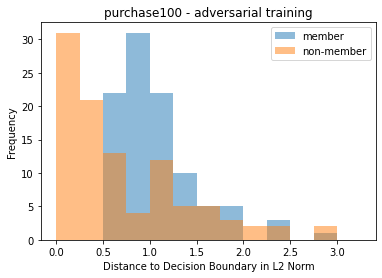

In [6]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.   0.01 0.01 0.04 0.04 0.06 0.06 0.08 0.08 0.09 0.09 0.1  0.1
 0.12 0.12 0.13 0.13 0.14 0.14 0.17 0.17 0.18 0.18 0.19 0.19 0.2  0.2
 0.21 0.21 0.23 0.23 0.24 0.24 0.25 0.25 0.29 0.29 0.32 0.32 0.33 0.33
 0.34 0.34 0.35 0.35 0.38 0.38 0.4  0.4  0.41 0.41 0.42 0.42 0.43 0.43
 0.45 0.45 0.46 0.46 1.  ]
[0.   0.01 0.01 0.02 0.02 0.05 0.05 0.09 0.09 0.1  0.1  0.12 0.12 0.13
 0.13 0.14 0.14 0.15 0.15 0.18 0.18 0.21 0.21 0.22 0.22 0.25 0.25 0.27
 0.27 0.29 0.29 0.38 0.38 0.41 0.41 0.42 0.42 0.47 0.47 0.54 0.54 0.61
 0.61 0.77 0.77 0.79 0.79 0.85 0.85 0.87 0.87 0.9  0.9  0.95 0.95 0.97
 0.97 0.98 0.98 1.   1.  ]
[4.8221474  3.8221474  2.8449762  2.829295   2.3800285  2.2991238
 2.1405716  1.9520652  1.8850394  1.8049924  1.7873546  1.7140516
 1.693899   1.6883422  1.5408459  1.5376383  1.5368844  1.5050483
 1.5033109  1.4044358  1.3572716  1.325626   1.3225564  1.3191307
 1.3095231  1.2508535  1.2397326  1.1963342  1.1897486  1.1772994
 1.1671518  1.0996958  1.0910187  1.0658556  1.061

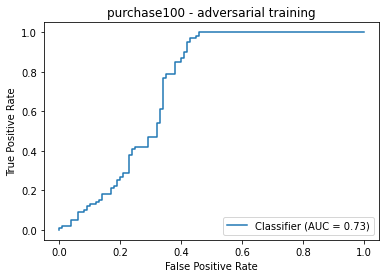

In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [8]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.21883313629250517 0.028713046306839
test correlation  0.5648416408256886 9.27324701722077e-10
